In [1]:
import os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils as vutils

from src.datasets import DatasetBuilder

from src.utils import seed_everything, get_config
from src.cf_methods.c3lt import models 

/data/leuven/365/vsc36567/miniconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-29 10:23:42.799570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748507022.817777 1011887 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748507022.823255 1011887 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748507022.838285 1011887 computation_placer.cc:177] computation placer alrea

In [2]:
seed_everything()

plt.style.use('seaborn-v0_8-darkgrid')
params = {"text.color" : "black"}
plt.rcParams.update(params)

## Load data

In [7]:
repo_path = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark'  # "D:\PycharmProjects\CF-Robustness-Benchmark" 
config_path = osp.join(repo_path, r'configs/train_classifier_fmnist.yaml')

config = get_config(config_path)
# config.data.classes = [9, 4, 3, 7]
# config.data.num_classes = 4
config.data_dir = osp.join(repo_path, config.data_dir)

BATCH_SIZE = config.batch_size
img_size = config.data.img_size

In [8]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [10]:
z = 100
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
nc = 1 # Number of channels
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
lr = 0.0002 # Learning rate for optimizers
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

## Build DCGAN object  

In [11]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
gen = models.Generator(latent_dim=z, ngf=ngf, nc=nc).to(device)
discr = models.Discriminator(ndf=ndf, nc=1).to(device)

gen.apply(weights_init);
discr.apply(weights_init);

In [13]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(BATCH_SIZE, z, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerG = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(discr.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 15

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discr.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discr(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discr(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discr(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(test_loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/150]	Loss_D: 1.9125	Loss_G: 1.3771	D(x): 0.3268	D(G(z)): 0.4964 / 0.2729
[0/15][50/150]	Loss_D: 0.5675	Loss_G: 2.6535	D(x): 0.7928	D(G(z)): 0.2442 / 0.0900
[0/15][100/150]	Loss_D: 0.7540	Loss_G: 4.0011	D(x): 0.7981	D(G(z)): 0.3697 / 0.0307
[1/15][0/150]	Loss_D: 0.7177	Loss_G: 2.6714	D(x): 0.7956	D(G(z)): 0.3398 / 0.0845
[1/15][50/150]	Loss_D: 1.0048	Loss_G: 1.5732	D(x): 0.4776	D(G(z)): 0.0856 / 0.2341
[1/15][100/150]	Loss_D: 0.5716	Loss_G: 1.8396	D(x): 0.7588	D(G(z)): 0.2247 / 0.1800
[2/15][0/150]	Loss_D: 0.6794	Loss_G: 1.5706	D(x): 0.6995	D(G(z)): 0.2225 / 0.2433
[2/15][50/150]	Loss_D: 0.5985	Loss_G: 1.5373	D(x): 0.6924	D(G(z)): 0.1734 / 0.2389
[2/15][100/150]	Loss_D: 0.5339	Loss_G: 2.0471	D(x): 0.8092	D(G(z)): 0.2403 / 0.1537
[3/15][0/150]	Loss_D: 0.8967	Loss_G: 1.0133	D(x): 0.5447	D(G(z)): 0.1675 / 0.4203
[3/15][50/150]	Loss_D: 0.6580	Loss_G: 2.2456	D(x): 0.7637	D(G(z)): 0.2683 / 0.1482
[3/15][100/150]	Loss_D: 0.7620	Loss_G: 1.7896	D(x): 0.7174	D(G

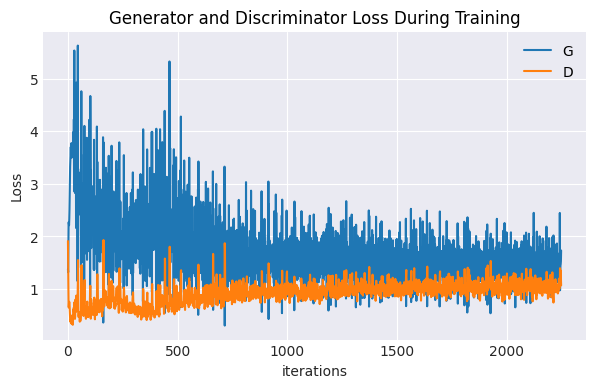

In [15]:
plt.figure(figsize=(7,4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

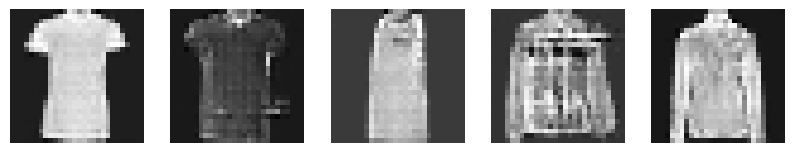

In [16]:
n_samples = 5
fig, axs = plt.subplots(1, n_samples, figsize=(10, 4))

noise_vector = torch.randn(BATCH_SIZE, z, 1, 1, device=device)
gen_images = gen(noise_vector).detach().cpu()

for j in range(n_samples):
    axs[j].imshow(gen_images[j].squeeze(0), cmap='gray')
    axs[j].axis("off")


In [17]:
save_dir = osp.join(repo_path,  r'src/cf_methods/c3lt/weights')

torch.save(gen.state_dict(), osp.join(save_dir, r'generator_fmnist_0_4.pth'))
torch.save(discr.state_dict(), osp.join(save_dir, r'discriminator_fmnist_0_4.pth'))

## Train AE

In [18]:
ae = models.ConvolutionalAuntoencoder(latent_dim=z, nc=nc, ndf=32, ngpu=1).to(device)

In [19]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    

    for data in tqdm(train_loader):
        images, _ = data
        images = images.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        outputs = ae(images)
        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


100%|██████████| 150/150 [00:00<00:00, 163.85it/s]


Epoch: 1 	Training Loss: 30.590628


100%|██████████| 150/150 [00:00<00:00, 180.31it/s]


Epoch: 2 	Training Loss: 15.997351


100%|██████████| 150/150 [00:00<00:00, 179.97it/s]


Epoch: 3 	Training Loss: 8.552797


100%|██████████| 150/150 [00:00<00:00, 180.14it/s]


Epoch: 4 	Training Loss: 4.470956


100%|██████████| 150/150 [00:00<00:00, 180.43it/s]


Epoch: 5 	Training Loss: 2.332425


100%|██████████| 150/150 [00:00<00:00, 179.49it/s]


Epoch: 6 	Training Loss: 1.266880


100%|██████████| 150/150 [00:00<00:00, 180.67it/s]


Epoch: 7 	Training Loss: 0.767337


100%|██████████| 150/150 [00:00<00:00, 181.04it/s]


Epoch: 8 	Training Loss: 0.565002


100%|██████████| 150/150 [00:00<00:00, 180.10it/s]


Epoch: 9 	Training Loss: 0.476022


100%|██████████| 150/150 [00:00<00:00, 180.89it/s]


Epoch: 10 	Training Loss: 0.429677


100%|██████████| 150/150 [00:00<00:00, 180.06it/s]


Epoch: 11 	Training Loss: 0.411162


100%|██████████| 150/150 [00:00<00:00, 180.33it/s]


Epoch: 12 	Training Loss: 0.401251


100%|██████████| 150/150 [00:00<00:00, 180.16it/s]


Epoch: 13 	Training Loss: 0.389227


100%|██████████| 150/150 [00:00<00:00, 179.20it/s]


Epoch: 14 	Training Loss: 0.383974


100%|██████████| 150/150 [00:00<00:00, 178.95it/s]


Epoch: 15 	Training Loss: 0.378293


100%|██████████| 150/150 [00:00<00:00, 177.10it/s]


Epoch: 16 	Training Loss: 0.362533


100%|██████████| 150/150 [00:00<00:00, 178.54it/s]


Epoch: 17 	Training Loss: 0.358058


100%|██████████| 150/150 [00:00<00:00, 178.99it/s]


Epoch: 18 	Training Loss: 0.351673


100%|██████████| 150/150 [00:00<00:00, 179.84it/s]


Epoch: 19 	Training Loss: 0.344169


100%|██████████| 150/150 [00:00<00:00, 180.77it/s]


Epoch: 20 	Training Loss: 0.340825


100%|██████████| 150/150 [00:00<00:00, 180.19it/s]


Epoch: 21 	Training Loss: 0.338641


100%|██████████| 150/150 [00:00<00:00, 180.58it/s]


Epoch: 22 	Training Loss: 0.329751


100%|██████████| 150/150 [00:00<00:00, 179.92it/s]


Epoch: 23 	Training Loss: 0.324405


100%|██████████| 150/150 [00:00<00:00, 180.78it/s]


Epoch: 24 	Training Loss: 0.322927


100%|██████████| 150/150 [00:00<00:00, 180.94it/s]


Epoch: 25 	Training Loss: 0.317633


100%|██████████| 150/150 [00:00<00:00, 180.21it/s]


Epoch: 26 	Training Loss: 0.319342


100%|██████████| 150/150 [00:00<00:00, 179.82it/s]


Epoch: 27 	Training Loss: 0.317158


100%|██████████| 150/150 [00:00<00:00, 179.62it/s]


Epoch: 28 	Training Loss: 0.307442


100%|██████████| 150/150 [00:00<00:00, 180.07it/s]


Epoch: 29 	Training Loss: 0.314381


100%|██████████| 150/150 [00:00<00:00, 179.87it/s]

Epoch: 30 	Training Loss: 0.304826


Recon loass: 0.00536


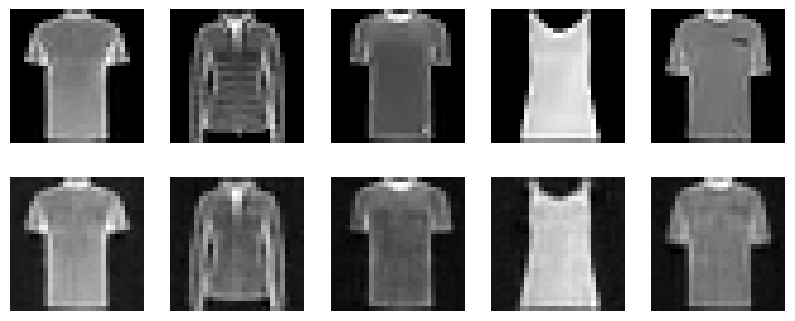

In [20]:
n_samples = 5
fig, axs = plt.subplots(2, n_samples, figsize=(10, 4))

images, _ = next(iter(train_loader))
recon = ae(images.to(device)).detach().cpu()
recon_loss = criterion(images, recon).item()

for j in range(n_samples):
    axs[0, j].imshow(images[j].squeeze(0), cmap='gray')
    axs[0, j].axis("off")
    axs[1, j].imshow(recon[j].squeeze(0), cmap='gray')
    axs[1, j].axis("off")

print(f'Recon loass: {recon_loss:.5f}')


In [21]:
save_dir = osp.join(repo_path, './src/cf_methods/c3lt/weights')
torch.save(ae.state_dict(), osp.join(save_dir, 'ae_fmnist_0_4.pth'))
torch.save(ae.encoder.state_dict(), osp.join(save_dir, 'encoder_fmnist_0_4.pth'))